# Przygotowanie

### Wczytanie bibliotek

In [ ]:
# Wczytaj
# - train.csv
# - model.h5

In [ ]:
!pip install tensorflow --upgrade

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Ataki

## FGSM atak

In [ ]:
def fgsm_attack(model, images, labels, c):
    """
    Wykonuje atak FGSM na zadanym modelu.

    Args:
        model: Wytrenowany model.
        images: Obrazy wejściowe (tensor).
        labels: Prawdziwe etykiety klas obrazów (tensor).
        epsilon: Wartość epsilon kontrolująca intensywność ataku.

    Returns:
        Tensor z wygenerowanymi obrazami adversarialnymi.
    """
    # Tworzymy tensor z danymi wejściowymi, aby obliczyć gradienty
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        tape.watch(images)
        # Przewidywanie wyników dla obrazów
        predictions = model(images)
        # Obliczamy stratę (najczęściej używana jest entropia krzyżowa)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

    # Obliczamy gradienty straty względem wejścia (obrazów)
    gradients = tape.gradient(loss, images)
    # Znak gradientów
    signed_grad = tf.sign(gradients)
    # Dodajemy perturbację o skali epsilon, tworząc obraz adversarialny
    adversarial_images = images + c * signed_grad
    # Ograniczamy wartości pikseli, aby pozostały w zakresie [0, 1]
    adversarial_images = tf.clip_by_value(adversarial_images, 0, 1)

    return adversarial_images

## PGD attack

In [ ]:
import tensorflow as tf

def pgd_attack(model, images, labels, epsilon, c, num_iterations, norm_type='linf', threshold=None):
    """
    Przeprowadza atak PGD z kontrolą normy perturbacji i możliwością wcześniejszego zakończenia.

    Parametry:
    - model: Model Keras lub TensorFlow
    - images: Obrazy wejściowe (batch)
    - labels: Etykiety one-hot dla obrazów
    - epsilon: Maksymalna wielkość perturbacji
    - c: Krok każdej iteracji
    - num_iterations: Maksymalna liczba iteracji
    - norm_type: Typ normy ('l2', 'linf')
    - threshold: Próg zmiany perturbacji dla wcześniejszego zakończenia (opcjonalny)

    Zwraca:
    - Adwersarialne obrazy
    """

    # Kopiowanie obrazów wejściowych, aby nie modyfikować oryginałów
    perturbed_images = tf.identity(images)

    if len(labels.shape) == 1:
        labels = tf.convert_to_tensor([labels])

    # Iteracyjne dodawanie perturbacji
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            # Śledzenie zmian w zmienionych obrazach
            tape.watch(perturbed_images)
            predictions = model(perturbed_images)
            loss = tf.keras.losses.categorical_crossentropy(labels, predictions)

        # Obliczanie gradientu straty względem obrazu
        gradient = tape.gradient(loss, perturbed_images)

        # Tworzenie perturbacji w zależności od wybranej normy
        if norm_type.lower() == 'linf':
            perturbation = c * tf.sign(gradient)
        elif norm_type.lower() == 'l2':
            norm = tf.sqrt(tf.reduce_sum(tf.square(gradient), axis=(1, 2, 3), keepdims=True))
            perturbation = c * gradient / (norm + 1e-10)  # Dodanie małej wartości zapobiega dzieleniu przez zero
        else:
            raise ValueError("Nieobsługiwana norma. Użyj 'l2' lub 'linf'.")

        # Aktualizacja obrazów poprzez dodanie perturbacji
        new_perturbed_images = perturbed_images + perturbation

        # Ograniczenie perturbacji do zakresu określonego przez epsilon
        new_perturbed_images = tf.clip_by_value(new_perturbed_images, images - epsilon, images + epsilon)

        # Zapewnienie, że wartości pikseli pozostają w zakresie [0, 1]
        new_perturbed_images = tf.clip_by_value(new_perturbed_images, 0, 1)

        # Sprawdzanie warunku wcześniejszego zakończenia, jeśli próg threshold jest ustawiony
        if threshold is not None:
            delta = tf.reduce_max(tf.abs(new_perturbed_images - perturbed_images))
            if delta < threshold:
                print(f"Zatrzymanie po {i + 1} iteracjach (zmiana < {threshold})")
                break

        perturbed_images = new_perturbed_images

    return perturbed_images


## C&W attack

In [ ]:
import tensorflow as tf
import numpy as np
import statistics as stat

def cw_attack(model, images, labels, norm='L2', c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01):
    """
    Atak CW z obsługą norm L2, Linf.
    Argumenty:
        model: Model Keras, na który przeprowadzany jest atak.
        images: Obrazy wejściowe, przeskalowane do zakresu [0, 1].
        labels: Prawdziwe etykiety dla ataku nietargetowanego lub etykiety docelowe dla ataku targetowanego (zakodowane w formie one-hot).
        norm: Typ normy dla perturbacji ('L2', 'Linf').
        c: Parametr regularyzacyjny kontrolujący rozmiar perturbacji.
        kappa: Margines pewności ataku.
        max_iter: Maksymalna liczba kroków optymalizacji.
        learning_rate: Współczynnik uczenia dla optymalizatora.
    Zwraca:
        Zmienione obrazy zawierające atak adversarialny.
    """

    # Konwersja obrazów i etykiet na tensory
    original_images = tf.convert_to_tensor(images, dtype=tf.float32)
    true_labels = tf.convert_to_tensor(labels, dtype=tf.float32)

    # Inicjalizacja perturbacji w przestrzeni tanh
    w = tf.Variable(tf.zeros_like(original_images), trainable=True, dtype=tf.float32)

    # Optymalizator
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Definicja funkcji f
    def f(x):
        logits = model(x)
        one_hot_labels = true_labels
        true_logits = tf.reduce_sum(one_hot_labels * logits, axis=1)
        other_logits = tf.reduce_max((1 - one_hot_labels) * logits - one_hot_labels * 1e4, axis=1)
        return tf.maximum(true_logits - other_logits, -kappa)

    # Definicja funkcji normy perturbacji
    def perturbation_norm(perturbed_images, original_images, norm):
        if norm == 'L2':
            return tf.reduce_sum(tf.square(perturbed_images - original_images), axis=[1, 2, 3])
        elif norm == 'Linf':
            return tf.reduce_max(tf.abs(perturbed_images - original_images), axis=[1, 2, 3])
        else:
            raise ValueError(f"Nieobsługiwana norma: {norm}")

    # Wykonanie optymalizacji
    prev_loss = 1e10
    for step in range(max_iter):
        with tf.GradientTape() as tape:
            # Mapowanie w z powrotem do przestrzeni obrazów przy użyciu funkcji tanh
            perturbed_images = 0.5 * (tf.tanh(w) + 1)

            # Obliczanie składowych funkcji straty
            norm_loss = perturbation_norm(perturbed_images, original_images, norm)
            f_loss = c * f(perturbed_images)
            total_loss = tf.reduce_sum(norm_loss + f_loss)

        # Obliczanie gradientów i aktualizacja wartości
        gradients = tape.gradient(total_loss, [w])
        optimizer.apply_gradients(zip(gradients, [w]))

        # Sprawdzanie warunku wcześniejszego zatrzymania
        if step % (max_iter // 10) == 0:
            #print(f"C:{c} Krok {step}/{max_iter}, Strata: {total_loss.numpy()}, norm_loss: {stat.mean(norm_loss.numpy())}, f_loss: {stat.mean(f_loss.numpy())}")
            if total_loss.numpy() > prev_loss:
                print("Atak zatrzymany z powodu konwergencji.")
                break
            prev_loss = total_loss.numpy()

    # Mapowanie końcowego w z powrotem do przestrzeni obrazów
    attack_images = 0.5 * (tf.tanh(w) + 1)
    return attack_images


# Wczytanie modelu

In [ ]:
model = tf.keras.models.load_model('model.h5')

### Wczytanie i obróbka danych

In [ ]:
data = pd.read_csv('train.csv')


X = data.iloc[:,1:]
Y = data.iloc[:,0]

X_reshaped = X.values.reshape(-1, 28, 28, 1)
X_reshaped = X_reshaped.astype("float32")/255

In [ ]:
images = X_reshaped[0:100]
labels = Y[0:100]
labels_encoded = to_categorical(labels, num_classes=10)

In [ ]:
# Przewidywanie na zbiorze testowym
y_pred = model.predict(images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Jeśli jest to klasyfikacja wieloklasowa
y_true = np.argmax(labels_encoded, axis=1)

original_confidences = tf.reduce_max(tf.nn.softmax(y_pred), axis=1)

NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-6-4edf0f42eb09>", line 2, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

could not find registered transfer manager for platform Host -- check target linkage
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_628]

In [ ]:
c = [50,10,1,0.3,0.1,0.05,0.01,0.001]

## Dodatkowe funkcje

In [ ]:
def calculate_metrics_for_attacks(model, original_images, labels, attack_type, c_values, attack_params=None):
    """
    Oblicza metryki klasyfikacyjne dla różnych ataków przy różnych wartościach c.

    Args:
        model: Wytrenowany model.
        original_images: Tensor zawierający oryginalne obrazy.
        labels: Tensor z prawdziwymi etykietami obrazów.
        attack_type: Typ ataku ('FGSM', 'PGD', 'CW', 'ZOO').
        c_values: Lista wartości c (odpowiednik epsilon) do perturbacji.
        attack_params: Dodatkowe parametry dla konkretnego ataku (dict).

    Returns:
        DataFrame z metrykami klasyfikacyjnymi dla każdego c i normy (jeśli dotyczy).
    """


    # Lista do przechowywania wyników
    metrics_results = []

    # Konwersja etykiet na one-hot encoding (jeśli wymaga tego model)
    labels_encoded = to_categorical(labels, num_classes=10)

    # Określenie norm w zależności od typu ataku
    norms = []
    if attack_type == 'FGSM':
        norms = ['Linf']  # FGSM używa tylko normy Linf
    elif attack_type == 'PGD' or attack_type == 'CW':
        norms = ['L2', 'Linf']  # PGD i CW mogą używać różnych norm
    else:
        raise ValueError(f"Unsupported attack type: {attack_type}")

    # Informacja o rozpoczęciu przetwarzania
    print(f"Rozpoczynam obliczanie metryk dla ataku {attack_type}...")

    # Pętla przez każdą normę i wartość c
    for norm in norms:
        print(f"Przetwarzam normę {norm}...")
        for c in c_values:
            iteration_start = time.time()
            print(f"Rozpoczynam generowanie obrazów atakowych dla c = {c}...")

            # Generowanie obrazów atakowych w zależności od typu ataku
            if attack_type == 'FGSM':
                adversarial_images = fgsm_attack(model, original_images, labels, c=c)
            elif (attack_type == 'CW' or attack_type == 'PGD') and c > 1 and norm == "L0":
                continue
            elif attack_type == 'PGD':
                adversarial_images = pgd_attack(
                    model,
                    original_images,
                    labels_encoded,
                    epsilon=attack_params.get('epsilon', 0.01), # Wartość c
                    c=c,
                    num_iterations=attack_params.get('num_iterations', 100),
                    norm_type=norm,  # Ustalona norma
                    threshold=attack_params.get('threshold', 0.01)
                )
            elif attack_type == 'CW':
                adversarial_images = cw_attack(
                    model,
                    original_images,
                    labels_encoded,
                    norm=norm,  # Ustalona norma
                    c=c,  # Wartość c
                    kappa=attack_params.get('kappa', 0),
                    max_iter=attack_params.get('max_iter', 1000),
                    learning_rate=attack_params.get('learning_rate', 0.01)
                )
            else:
                raise ValueError(f"Unsupported attack type: {attack_type}")

            print("Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...")

            # Obliczanie predykcji dla obrazów adversarialnych
            adversarial_predictions = model(adversarial_images)
            adversarial_labels = tf.argmax(adversarial_predictions, axis=1)

            # Konwersja etykiet i predykcji na format NumPy
            true_labels = tf.argmax(labels_encoded, axis=1).numpy()
            predicted_labels = adversarial_labels.numpy()

            # Obliczanie metryk klasyfikacyjnych
            print("Obliczanie metryk klasyfikacyjnych...")
            accuracy = accuracy_score(true_labels, predicted_labels)
            precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
            recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
            f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

            # Dodanie wyników do listy
            metrics_results.append({
                'Attack Type': attack_type,
                'Norm': norm,
                'c': c,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1
            })
            iteration_end = time.time()
            iteration_time = iteration_end - iteration_start
            print(f"Metryki obliczone dla c = {c}, norma = {norm}. Czas iteracji: {iteration_time:.2f} sekund.")

    # Informacja o zakończeniu obliczeń
    print("Wszystkie metryki obliczone. Generowanie ramki danych...")

    # Konwersja wyników do ramki danych
    metrics_df = pd.DataFrame(metrics_results)
    print("Ramka danych z metrykami gotowa.")
    return metrics_df


In [ ]:
fgsm_metrics = calculate_metrics_for_attacks(model, images, labels, 'FGSM',c)

Rozpoczynam obliczanie metryk dla ataku FGSM...
Przetwarzam normę Linf...
Rozpoczynam generowanie obrazów atakowych dla c = 50...
Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...
Obliczanie metryk klasyfikacyjnych...
Metryki obliczone dla c = 50, norma = Linf. Czas iteracji: 2.88 sekund.
Rozpoczynam generowanie obrazów atakowych dla c = 10...
Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...
Obliczanie metryk klasyfikacyjnych...
Metryki obliczone dla c = 10, norma = Linf. Czas iteracji: 0.07 sekund.
Rozpoczynam generowanie obrazów atakowych dla c = 1...
Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...
Obliczanie metryk klasyfikacyjnych...
Metryki obliczone dla c = 1, norma = Linf. Czas iteracji: 0.08 sekund.
Rozpoczynam generowanie obrazów atakowych dla c = 0.3...
Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...
Obliczanie metryk klasyfikacyjnych...
Metryki obliczone dla c = 0.3, norma = Linf. Czas iteracji:

In [ ]:
fgsm_metrics

,Attack Type,Norm,c,Accuracy,Precision,Recall,F1 Score
0,FGSM,Linf,50.000,0.06,0.025191,0.06,0.019750
1,FGSM,Linf,10.000,0.06,0.025191,0.06,0.019750
2,FGSM,Linf,1.000,0.06,0.025191,0.06,0.019750
3,FGSM,Linf,0.300,0.08,0.058191,0.08,0.044824
4,FGSM,Linf,0.100,0.20,0.524390,0.20,0.221430
5,FGSM,Linf,0.050,0.51,0.586430,0.51,0.508619
6,FGSM,Linf,0.010,1.00,1.000000,1.00,1.000000
7,FGSM,Linf,0.001,1.00,1.000000,1.00,1.000000


In [ ]:
pgd_metrics = calculate_metrics_for_attacks(
    model,
    images,
    labels,
    'PGD',
    c,
    attack_params={
        'epsilon': 0.1,
        'num_iterations': 100,
        'threshold': None
    }
)

Rozpoczynam obliczanie metryk dla ataku PGD...
Przetwarzam normę L2...
Rozpoczynam generowanie obrazów atakowych dla c = 50...
Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...
Obliczanie metryk klasyfikacyjnych...
Metryki obliczone dla c = 50, norma = L2. Czas iteracji: 37.45 sekund.
Rozpoczynam generowanie obrazów atakowych dla c = 10...
Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...
Obliczanie metryk klasyfikacyjnych...
Metryki obliczone dla c = 10, norma = L2. Czas iteracji: 37.90 sekund.
Rozpoczynam generowanie obrazów atakowych dla c = 1...
Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...
Obliczanie metryk klasyfikacyjnych...
Metryki obliczone dla c = 1, norma = L2. Czas iteracji: 36.69 sekund.
Rozpoczynam generowanie obrazów atakowych dla c = 0.3...
Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...
Obliczanie metryk klasyfikacyjnych...
Metryki obliczone dla c = 0.3, norma = L2. Czas iteracji: 37.50 s

In [ ]:
pgd_metrics

,Attack Type,Norm,c,Accuracy,Precision,Recall,F1 Score
0,PGD,L2,50.000,0.06,0.003711,0.06,0.006990
1,PGD,L2,10.000,0.05,0.003297,0.05,0.006186
2,PGD,L2,1.000,0.00,0.000000,0.00,0.000000
3,PGD,L2,0.300,0.02,0.111538,0.02,0.021000
4,PGD,L2,0.100,0.04,0.042874,0.04,0.026000
5,PGD,L2,0.050,0.06,0.049017,0.06,0.035218
6,PGD,L2,0.010,0.33,0.380060,0.33,0.292604
7,PGD,L2,0.001,1.00,1.000000,1.00,1.000000
8,PGD,Linf,50.000,0.06,0.003750,0.06,0.007059
9,PGD,Linf,10.000,0.06,0.003750,0.06,0.007059


In [ ]:
cw_metrics = calculate_metrics_for_attacks(
    model,
    images,
    labels,
    'CW',
    c,
    attack_params={
        'kappa': 0,
        'max_iter': 100,
        'learning_rate': 0.01
    }
)

Rozpoczynam obliczanie metryk dla ataku CW...
Przetwarzam normę L2...
Rozpoczynam generowanie obrazów atakowych dla c = 50...
Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...
Obliczanie metryk klasyfikacyjnych...
Metryki obliczone dla c = 50, norma = L2. Czas iteracji: 9.85 sekund.
Rozpoczynam generowanie obrazów atakowych dla c = 10...
Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...
Obliczanie metryk klasyfikacyjnych...
Metryki obliczone dla c = 10, norma = L2. Czas iteracji: 5.47 sekund.
Rozpoczynam generowanie obrazów atakowych dla c = 1...
Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...
Obliczanie metryk klasyfikacyjnych...
Metryki obliczone dla c = 1, norma = L2. Czas iteracji: 4.74 sekund.
Rozpoczynam generowanie obrazów atakowych dla c = 0.3...
Obrazy atakowe wygenerowane. Rozpoczynam klasyfikację przez model...
Obliczanie metryk klasyfikacyjnych...
Metryki obliczone dla c = 0.3, norma = L2. Czas iteracji: 4.61 sekund

In [ ]:
cw_metrics

,Attack Type,Norm,c,Accuracy,Precision,Recall,F1 Score
0,CW,L2,50.000,0.00,0.000000,0.00,0.000000
1,CW,L2,10.000,0.00,0.000000,0.00,0.000000
2,CW,L2,1.000,0.06,0.003600,0.06,0.006792
3,CW,L2,0.300,0.06,0.003600,0.06,0.006792
4,CW,L2,0.100,0.06,0.003600,0.06,0.006792
5,CW,L2,0.050,0.06,0.003600,0.06,0.006792
6,CW,L2,0.010,0.06,0.003600,0.06,0.006792
7,CW,L2,0.001,0.06,0.003600,0.06,0.006792
8,CW,Linf,50.000,0.02,0.006667,0.02,0.010000
9,CW,Linf,10.000,0.02,0.006667,0.02,0.010000


In [ ]:
combined_metrics = pd.concat([fgsm_metrics, pgd_metrics, cw_metrics], ignore_index=True)
combined_metrics

,Attack Type,Norm,c,Accuracy,Precision,Recall,F1 Score
0,FGSM,Linf,50.000,0.06,0.025191,0.06,0.019750
1,FGSM,Linf,10.000,0.06,0.025191,0.06,0.019750
2,FGSM,Linf,1.000,0.06,0.025191,0.06,0.019750
3,FGSM,Linf,0.300,0.08,0.058191,0.08,0.044824
4,FGSM,Linf,0.100,0.20,0.524390,0.20,0.221430
...,...,...,...,...,...,...,...
63,CW,L0,0.300,0.00,0.000000,0.00,0.000000
64,CW,L0,0.100,0.00,0.000000,0.00,0.000000
65,CW,L0,0.050,0.00,0.000000,0.00,0.000000
66,CW,L0,0.010,0.00,0.000000,0.00,0.000000


In [ ]:
combined_metrics.to_csv('metrics.csv', index=False)

NameError: name 'combined_metrics' is not defined

### Wizualizacja

In [ ]:
def visualize_single_attack(model, image, label, attack_method, c_values, norm_type='L2'):
    """
    Wyświetla obrazy wynikowe dla pojedynczego ataku przy różnych wartościach c i ustalonej normie.

    Args:
        model: Wytrenowany model.
        image: Pojedynczy obraz (tensor).
        label: Prawdziwa etykieta (tensor, one-hot).
        attack_method: Nazwa ataku ('FGSM', 'PGD', 'CW', 'ZOO').
        c_values: Lista wartości parametru c.
        norm_type: Wybrana norma ('L2' lub 'Linf').

    Raises:
        ValueError: Jeśli norma nie jest obsługiwana przez wybrany atak.
    """
    label_encoded = to_categorical(label, num_classes=10)

    # Dodanie wymiaru batch do obrazu
    image = tf.expand_dims(image, axis=0)
    label = tf.expand_dims(label, axis=0)
    true_label = tf.argmax(label).numpy()

    # Obliczenie predykcji i pewności dla oryginalnego obrazu
    original_pred = model(image)
    original_confidence = tf.reduce_max(tf.nn.softmax(original_pred)).numpy() * 100

    # Liczba obrazów (oryginał + len(c_values)) i układ siatki
    num_images = len(c_values) + 1
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols  # Zaokrąglenie w górę

    # Ustawienie rozmiaru wykresu
    plt.figure(figsize=(5 * num_cols, 5 * num_rows))
    plt.suptitle(f"Typ Normy: {norm_type}", fontsize=20, y=0.99)

    # Wyświetlenie oryginalnego obrazu
    plt.subplot(num_rows, num_cols, 1)
    plt.imshow(image[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f"Oryginał\nLabel: {label[0]}\nPewność: {original_confidence:.2f}%", fontsize=14)

    # Iteracja po wartościach c
    for idx, c in enumerate(c_values, start=2):
        # Wybór ataku
        if attack_method == 'FGSM' and norm_type == 'Linf':
            perturbed_image = fgsm_attack(
                model=model,
                images=image,
                labels=label,
                c=c
            )
        elif attack_method == 'PGD' and norm_type in ['L2', 'Linf']:
            perturbed_image = pgd_attack(
                model=model,
                images=image,
                labels=label_encoded,
                epsilon=0.1,
                c=c,
                num_iterations=100,
                norm_type=norm_type
            )
        elif attack_method == 'CW' and norm_type in ['L2', 'Linf']:
            perturbed_image = cw_attack(
                model=model,
                images=image,
                labels=label_encoded,
                norm=norm_type,
                c=c,
                kappa=0,
                max_iter=1000,
                learning_rate=0.01
            )
        else:
            raise ValueError(f"Wybrany atak '{attack_method}' nie obsługuje normy '{norm_type}'.")

        # Obliczenie predykcji dla obrazu po ataku
        pred = model(perturbed_image)
        pred_label = tf.argmax(pred, axis=1).numpy()[0]
        confidence = tf.reduce_max(tf.nn.softmax(pred)).numpy() * 100
        logits = pred.numpy().squeeze()  # Logity obrazu po ataku

        # Wyświetlenie obrazu
        plt.subplot(num_rows, num_cols, idx)
        plt.imshow(perturbed_image[0].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f"c: {c}\nPrzewidziana etykieta: {pred_label}\nPewność: {confidence:.2f}%", fontsize=14)

    plt.tight_layout()
    plt.show()


In [ ]:
# Przykładowy obraz, etykieta i wartość c
sample_image = images[5]  # Zakładamy, że images to zbiór obrazów
sample_label = labels[5]  # Zakładamy, że labels to zbiór etykiet

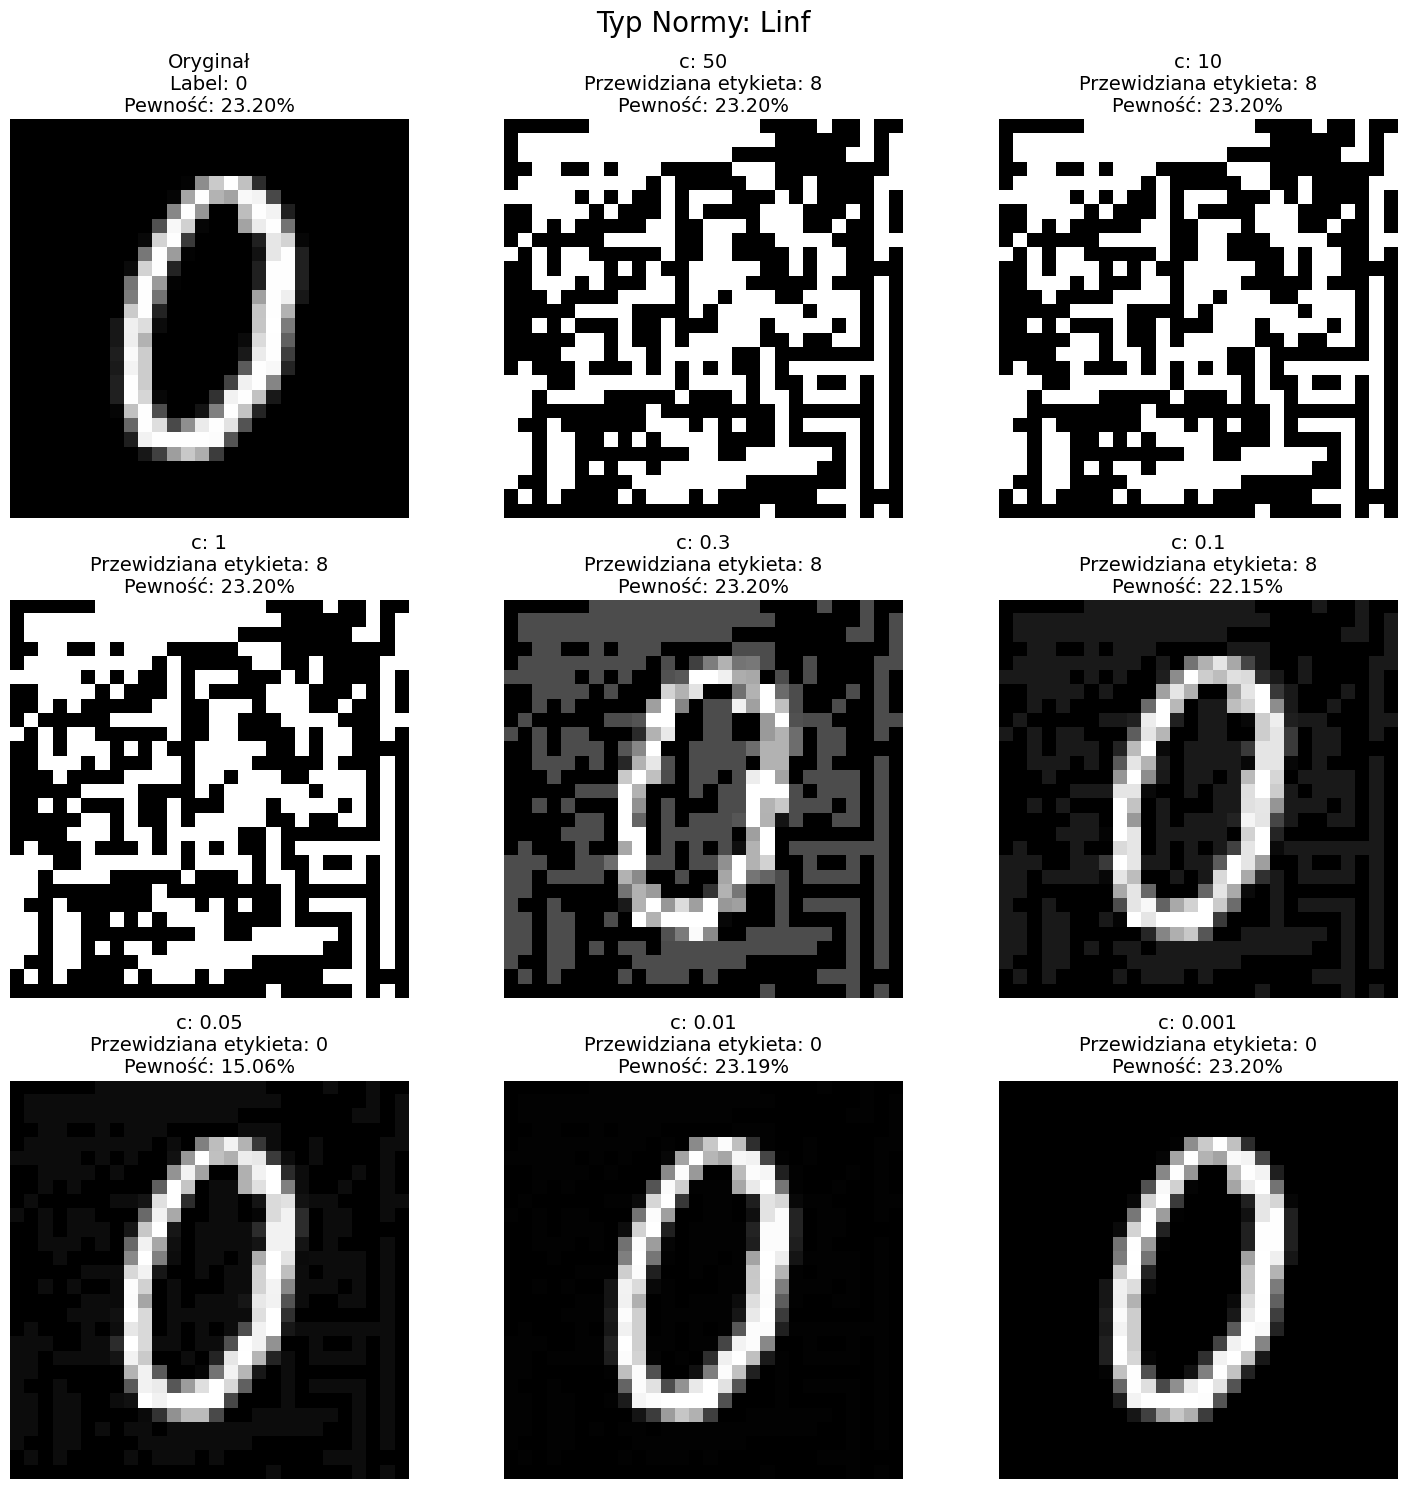

In [ ]:
visualize_single_attack(model, sample_image, sample_label, "FGSM", c, "Linf")

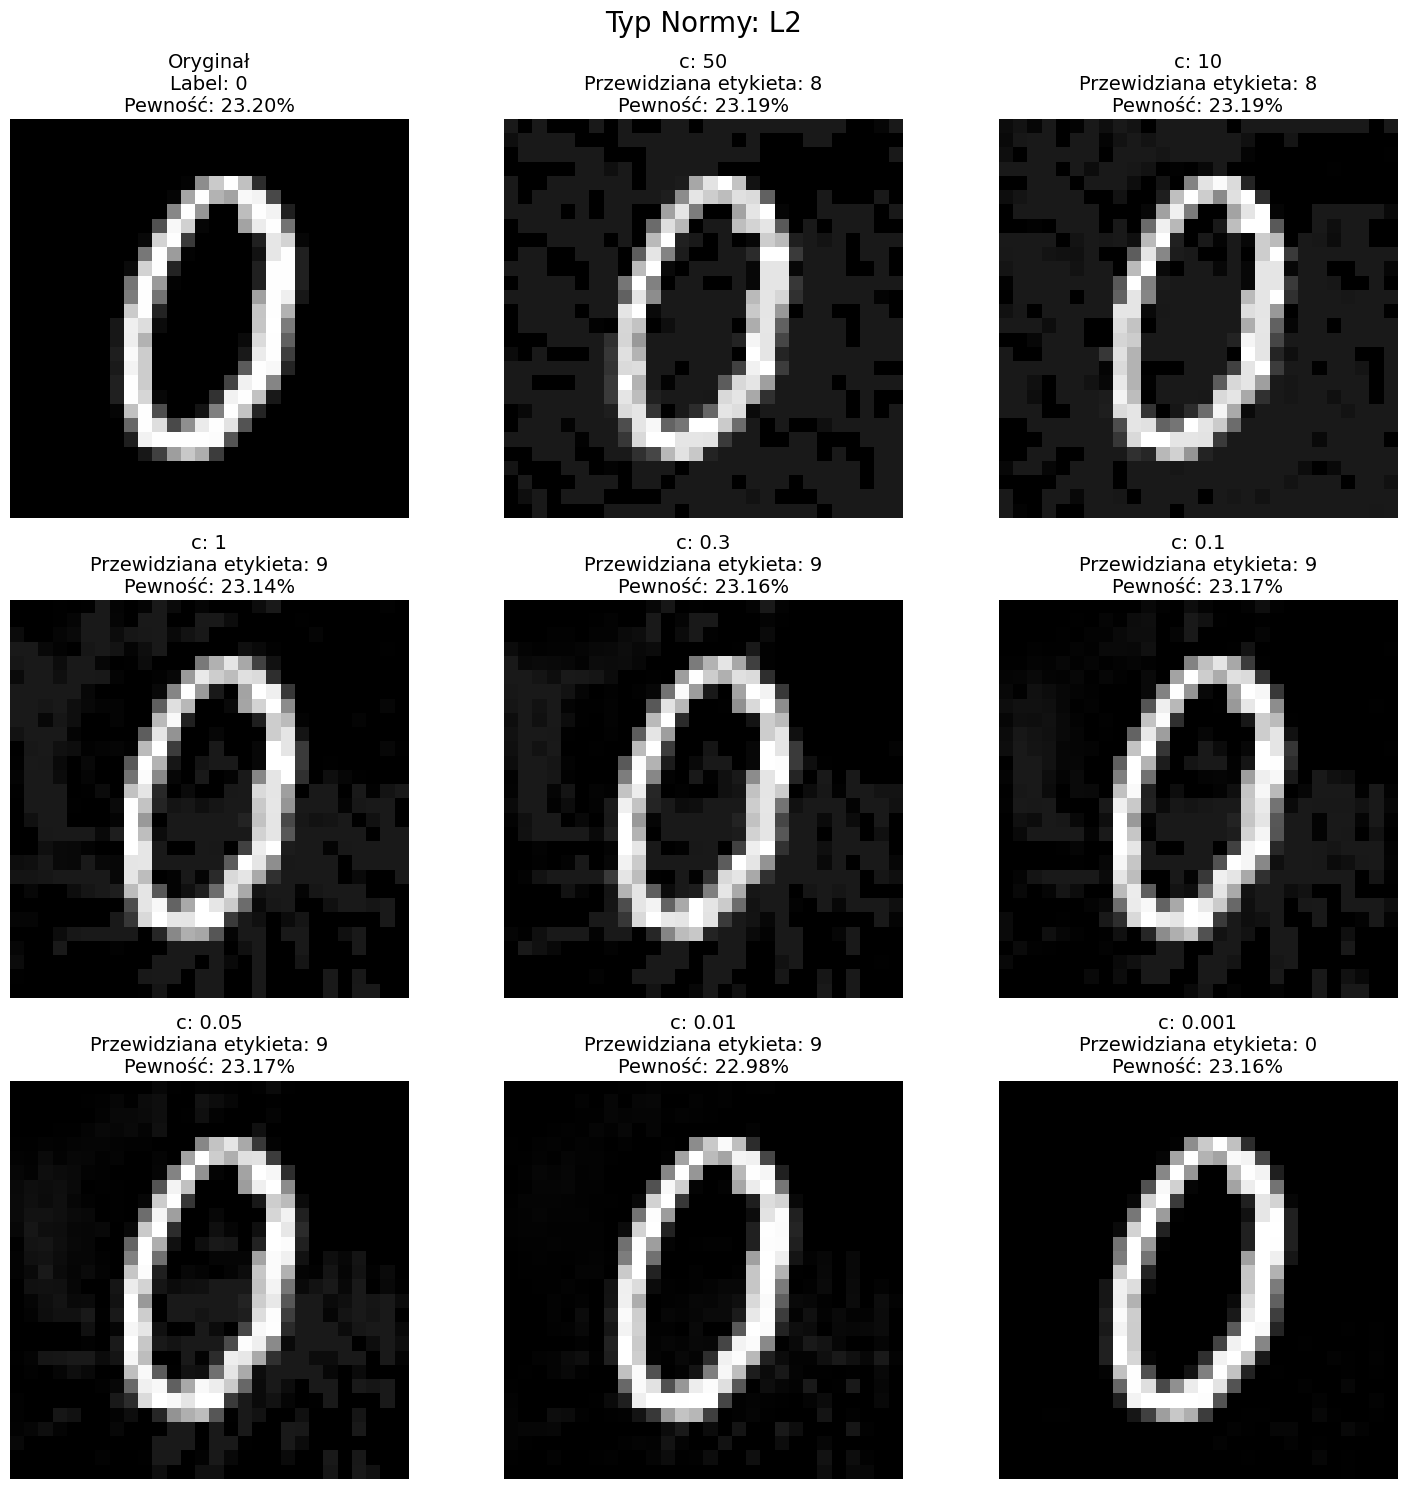

In [ ]:
visualize_single_attack(model, sample_image, sample_label, "PGD", c, "L2")

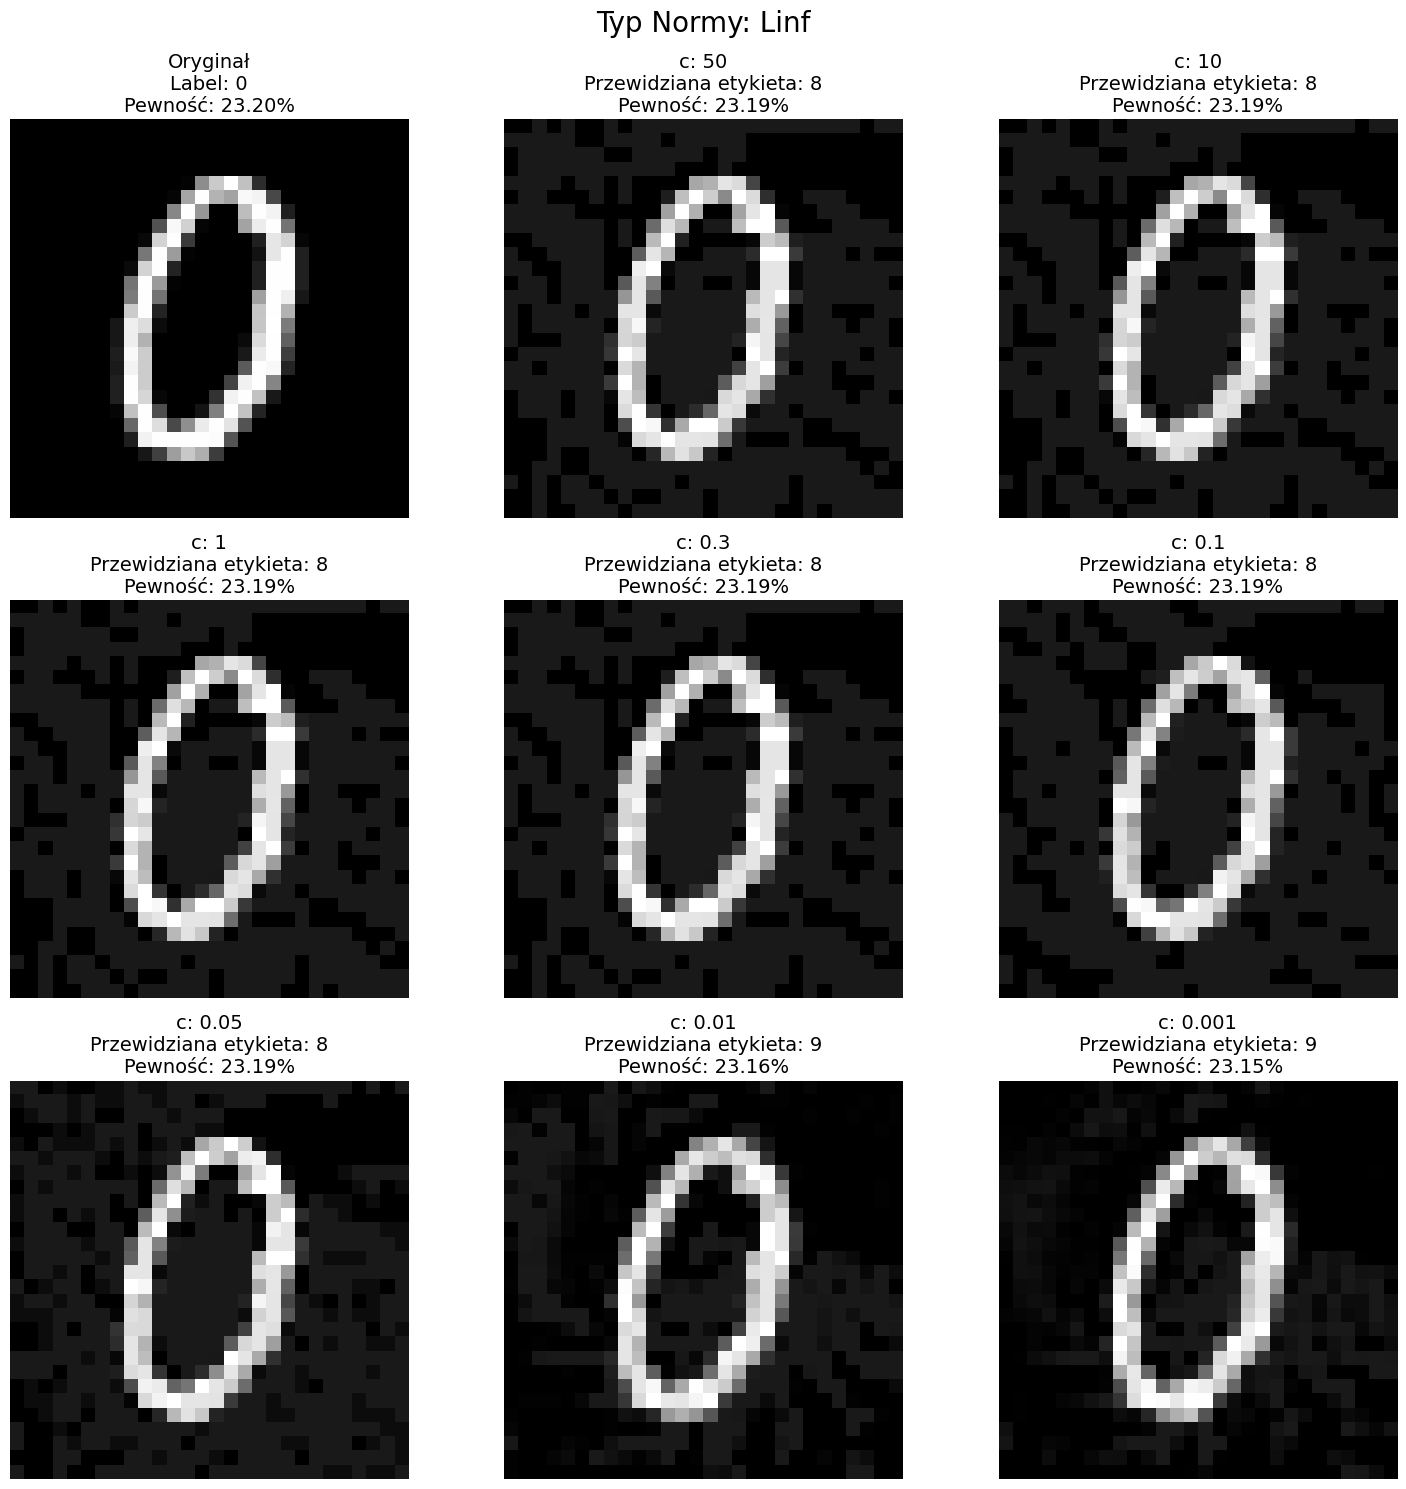

In [ ]:
visualize_single_attack(model, sample_image, sample_label, "PGD", c, "Linf")

C:50 Step 0/1000, Loss: 180.13412475585938, norm_loss: 180.13412475585938, f_loss: 0.0
C:50 Step 100/1000, Loss: 23.420127868652344, norm_loss: 23.420127868652344, f_loss: 0.0
C:50 Step 200/1000, Loss: 8.000458717346191, norm_loss: 8.000458717346191, f_loss: 0.0
C:50 Step 300/1000, Loss: 4.153247833251953, norm_loss: 4.153247833251953, f_loss: 0.0
C:50 Step 400/1000, Loss: 2.5918564796447754, norm_loss: 2.5918564796447754, f_loss: 0.0
C:50 Step 500/1000, Loss: 1.7918701171875, norm_loss: 1.7918701171875, f_loss: 0.0
C:50 Step 600/1000, Loss: 1.7983914613723755, norm_loss: 1.7983914613723755, f_loss: 0.0
Attack stopped due to convergence.
C:10 Step 0/1000, Loss: 180.13412475585938, norm_loss: 180.13412475585938, f_loss: 0.0
C:10 Step 100/1000, Loss: 23.420127868652344, norm_loss: 23.420127868652344, f_loss: 0.0
C:10 Step 200/1000, Loss: 8.000458717346191, norm_loss: 8.000458717346191, f_loss: 0.0
C:10 Step 300/1000, Loss: 4.153247833251953, norm_loss: 4.153247833251953, f_loss: 0.0
C:10

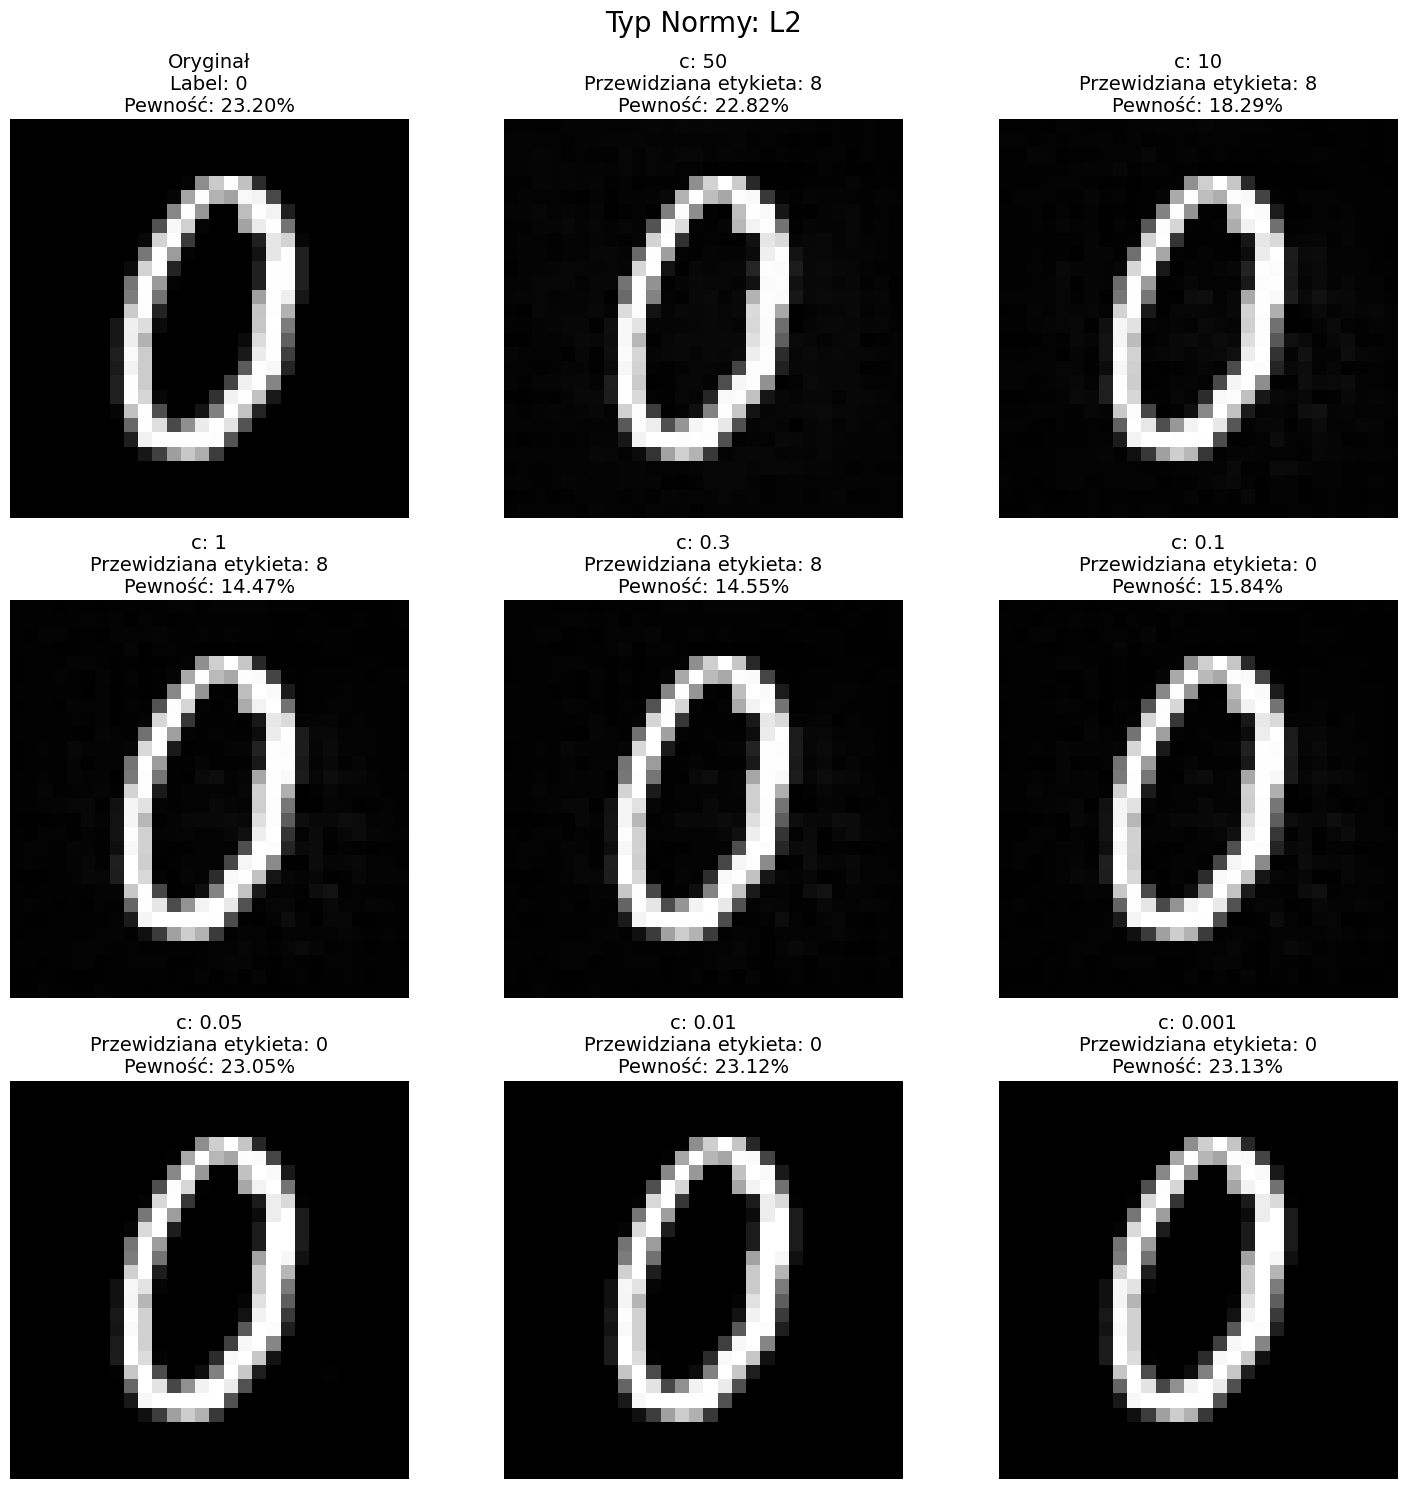

In [ ]:
visualize_single_attack(model, sample_image, sample_label, "CW", c, "L2")

C:50 Step 0/1000, Loss: 0.5, norm_loss: 0.5, f_loss: 0.0
C:50 Step 100/1000, Loss: 0.37555915117263794, norm_loss: 0.37555915117263794, f_loss: 0.0
C:50 Step 200/1000, Loss: 0.30000001192092896, norm_loss: 0.30000001192092896, f_loss: 0.0
C:50 Step 300/1000, Loss: 0.23962336778640747, norm_loss: 0.23962336778640747, f_loss: 0.0
C:50 Step 400/1000, Loss: 0.1904304027557373, norm_loss: 0.1904304027557373, f_loss: 0.0
C:50 Step 500/1000, Loss: 0.15104079246520996, norm_loss: 0.15104079246520996, f_loss: 0.0
C:50 Step 600/1000, Loss: 0.11960786581039429, norm_loss: 0.11960786581039429, f_loss: 0.0
C:50 Step 700/1000, Loss: 0.09296387434005737, norm_loss: 0.09296387434005737, f_loss: 0.0
C:50 Step 800/1000, Loss: 0.07252007722854614, norm_loss: 0.07252007722854614, f_loss: 0.0
C:50 Step 900/1000, Loss: 0.055634915828704834, norm_loss: 0.055634915828704834, f_loss: 0.0
C:10 Step 0/1000, Loss: 0.5, norm_loss: 0.5, f_loss: 0.0
C:10 Step 100/1000, Loss: 0.37555915117263794, norm_loss: 0.3755591

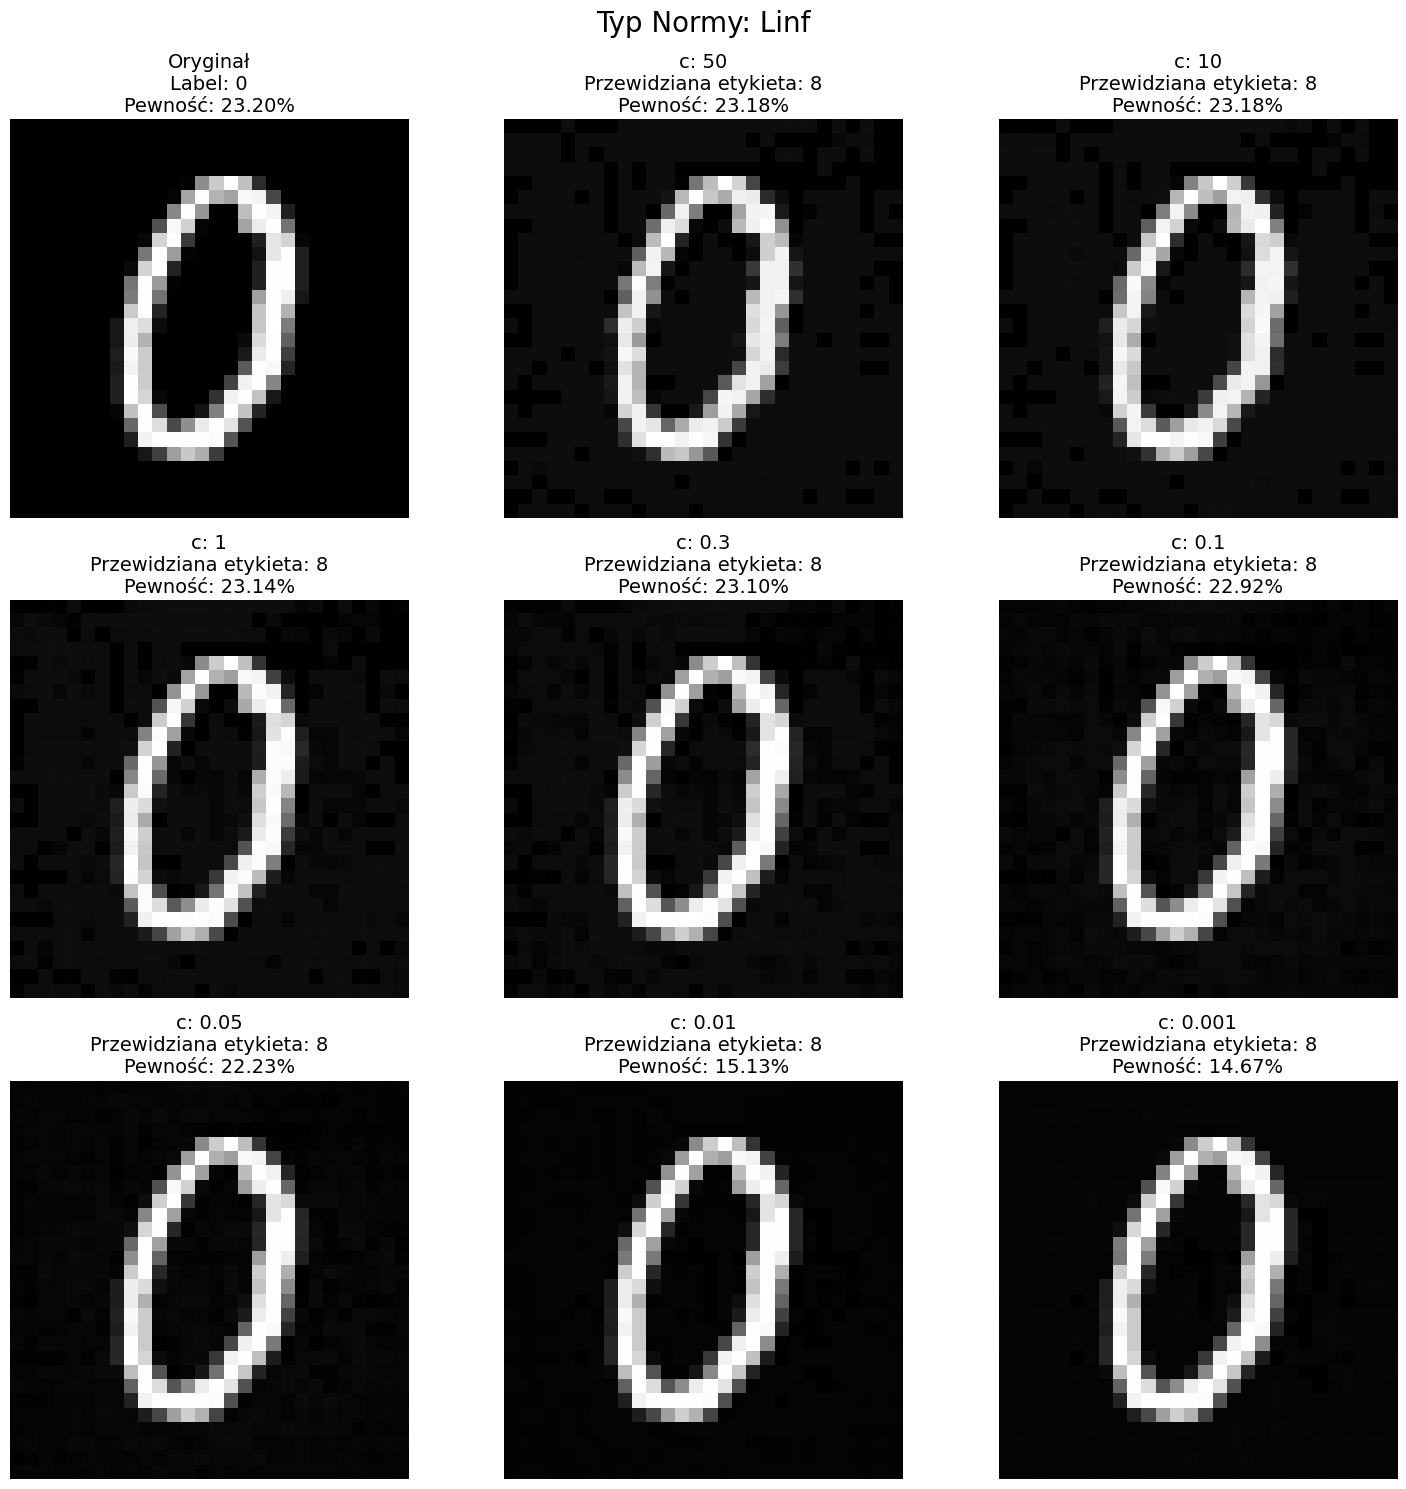

In [ ]:
visualize_single_attack(model, sample_image, sample_label, "CW", c, "Linf")